In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import os
os.getcwd()

'/Users/keyang/Desktop/Tripalink/usc定价模型'

In [3]:
df_train = pd.read_excel('/Users/keyang/Desktop/Tripalink/usc定价模型/USCdata.xlsx')

In [4]:
df_train.columns

Index(['Apt Name', 'Address', 'zip code', 'Rent', 'Bed', 'Bath', 'Size',
       'Cooling/Heat', 'Pets', 'Parking', 'Laundry', 'Pool', 'Gym',
       'furnished', 'Year Built', 'Within Safe', 'walk to USC', 'distance',
       'location', 'Walk Score', 'Transit Score', 'Shuttle', 'Brand', 'Story',
       'Total Units'],
      dtype='object')

In [5]:
df_train.drop(columns=['Apt Name'], inplace=True)
df_train.drop(columns=['Address'], inplace=True)
df_train['zip code']=df_train['zip code'].astype(str)

In [6]:
df_train['bed temp'] = df_train['Bed']
df_train['bed temp'].loc[df_train['bed temp']==0.5]=1
df_train['Rent/bed'] = df_train['Rent'] / df_train['bed temp']
df_train['Size'] = df_train['Size'] / df_train['bed temp']

# Outlier

In [7]:
df_train['Rent/bed'].describe()

count     192.000000
mean     1524.829960
std       635.815426
min       391.666667
25%      1140.000000
50%      1437.500000
75%      1753.750000
max      6670.000000
Name: Rent/bed, dtype: float64

In [8]:
df_train = df_train.drop(df_train[df_train['Rent']>10000].index)

In [9]:
df_train['Rent'].describe()

count     191.000000
mean     2883.130890
std      1566.442261
min      1195.000000
25%      1800.000000
50%      2495.000000
75%      3395.000000
max      8700.000000
Name: Rent, dtype: float64

# Variables

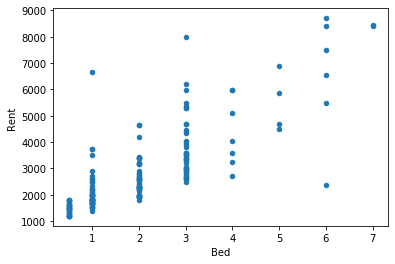

In [10]:
var = 'Bed'
data = pd.concat([df_train['Rent'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Rent')#, ylim=(0,800000));

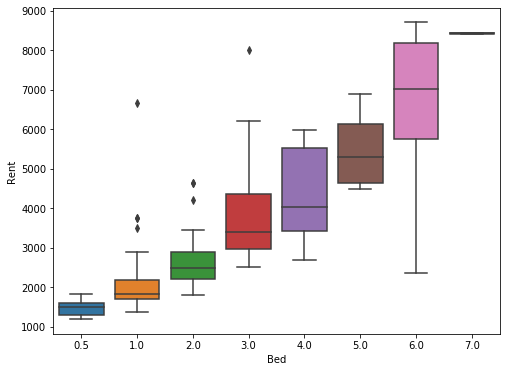

In [11]:
var = 'Bed'
data = pd.concat([df_train['Rent'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Rent", data=data)
#fig.axis(ymin=0, ymax=800000);

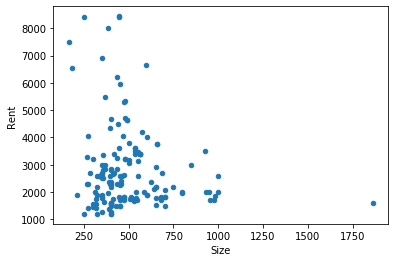

In [12]:
var = 'Size'
data = pd.concat([df_train['Rent'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Rent')

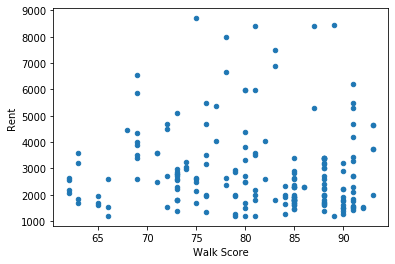

In [13]:
var = 'Walk Score'
data = pd.concat([df_train['Rent'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Rent')

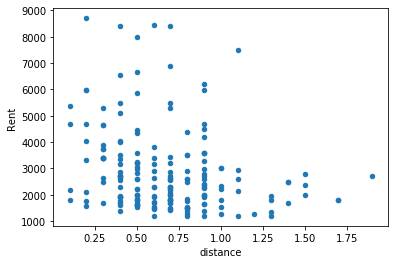

In [14]:
var = 'distance'
data = pd.concat([df_train['Rent'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Rent')

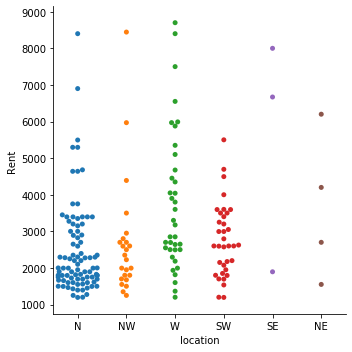

In [15]:
sns.catplot(kind="swarm", x="location", y="Rent", data=df_train)

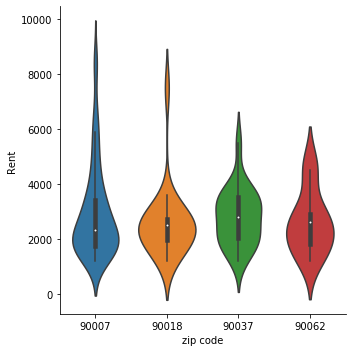

In [16]:
sns.catplot(kind="violin", x="zip code", y="Rent", data=df_train)

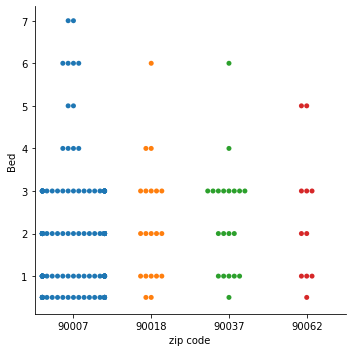

In [17]:
sns.catplot(kind="swarm", x="zip code", y="Bed", data=df_train)

# Correlation

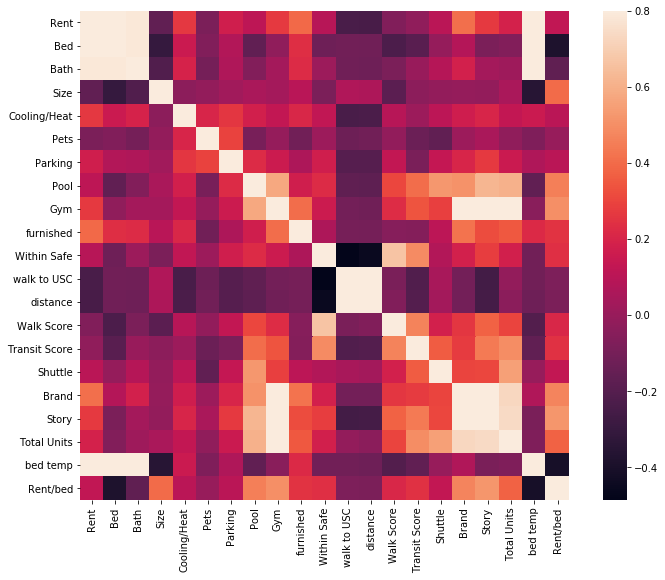

In [18]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

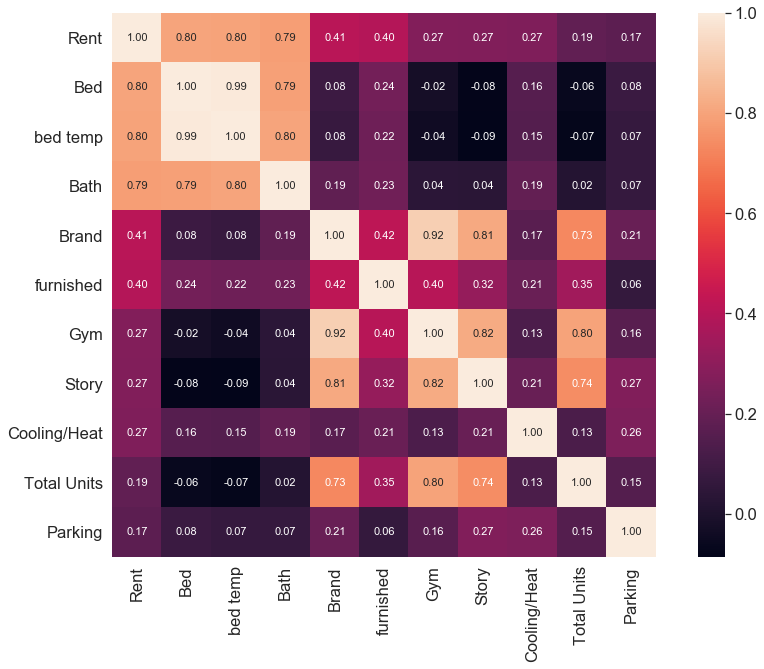

In [19]:
#saleprice correlation matrix
plt.figure(figsize=(15,10))

k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Rent')['Rent'].index
#cm = np.corrcoef(df_train[cols].values.T)
cm = df_train[cols].corr()
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


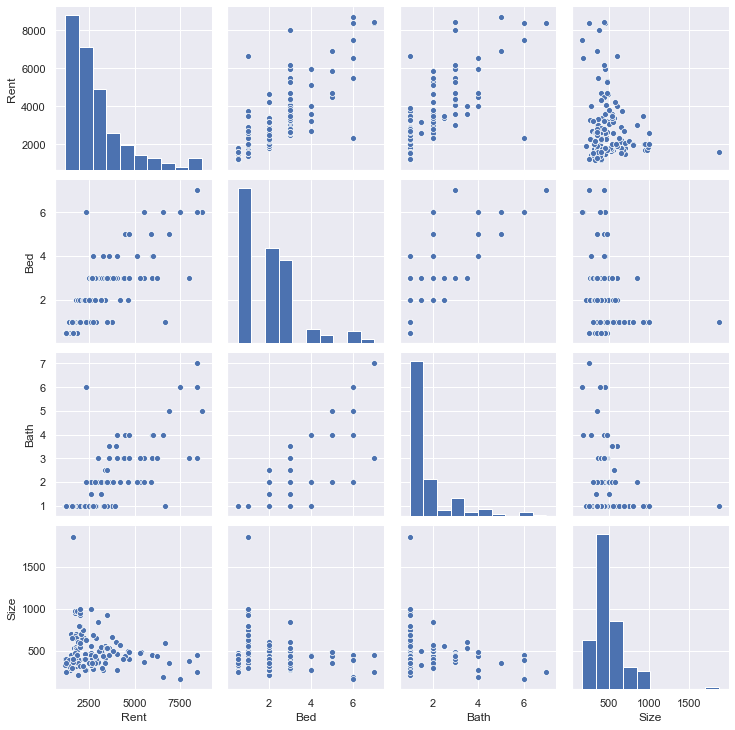

In [20]:
#scatterplot
sns.set()
cols = ['Rent', 'Bed', 'Bath', 'Size']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

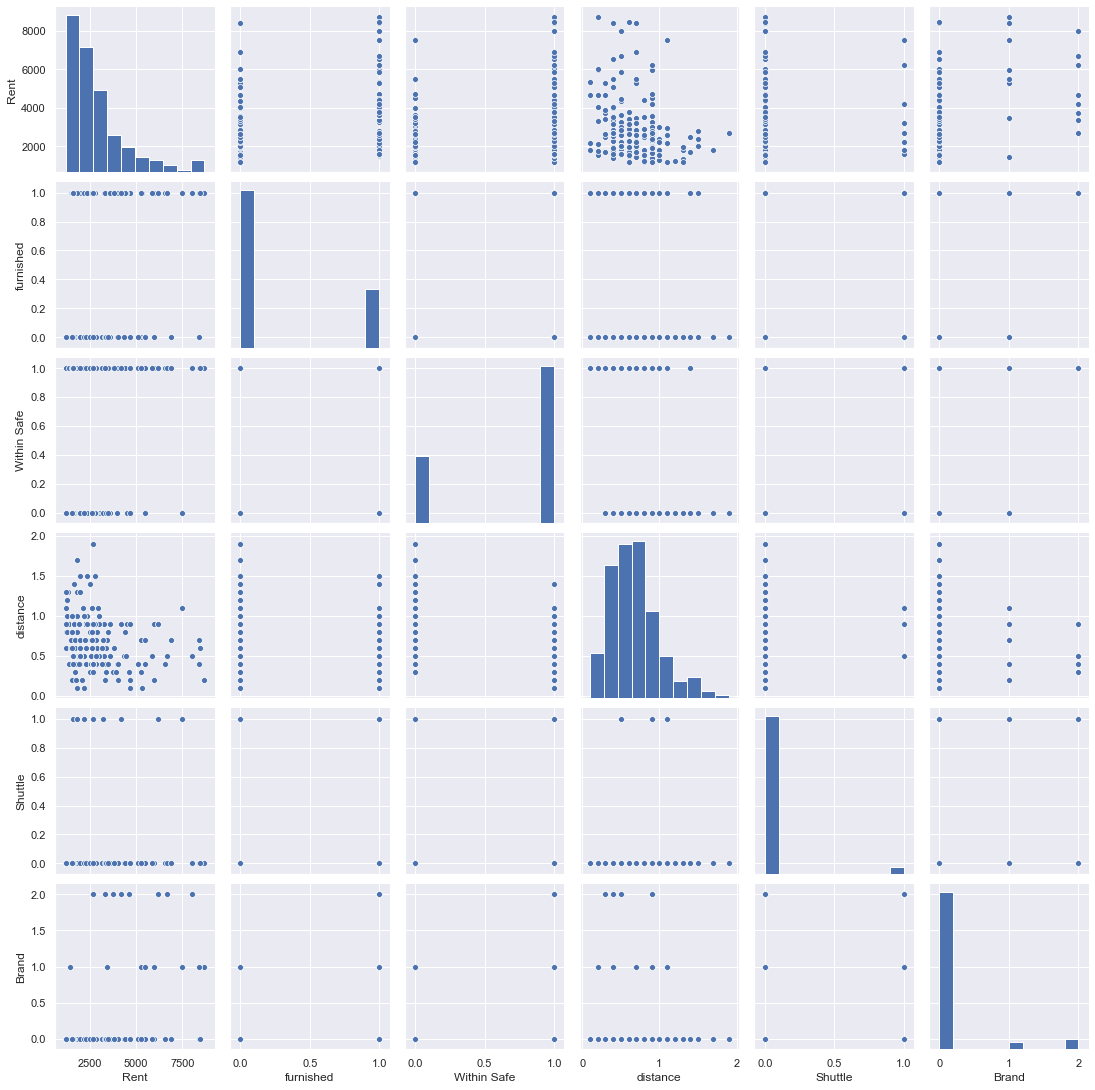

In [21]:
sns.set()
cols = ['Rent', 'furnished', 'Year Built', 'Within Safe', 'distance',
       'location',  'Shuttle', 'Brand']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

In [22]:
df_train.drop(columns=['walk to USC'],inplace=True) 


## Data for XGB

In [23]:
df_train_xgb = df_train.copy()

# Missing Data

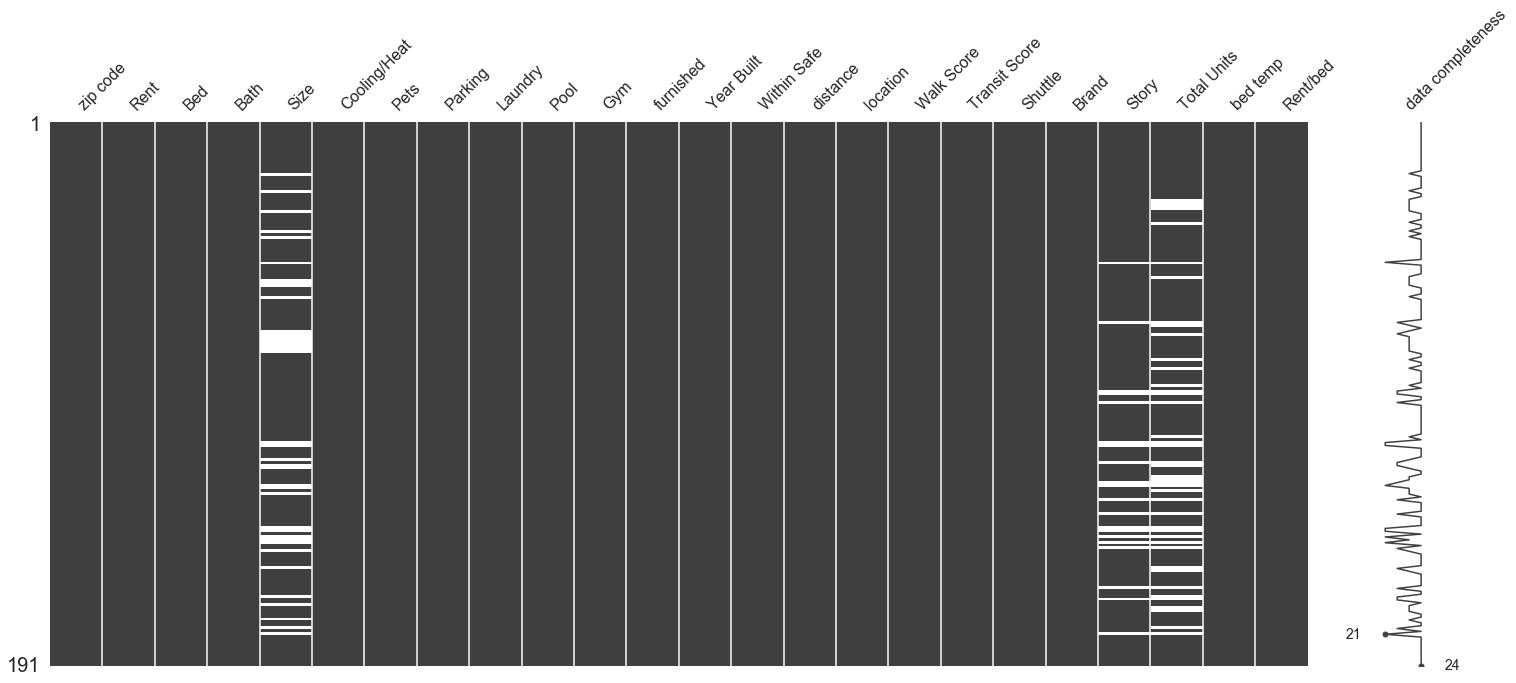

In [24]:
import missingno as msno
msno.matrix(df_train, labels=True) 

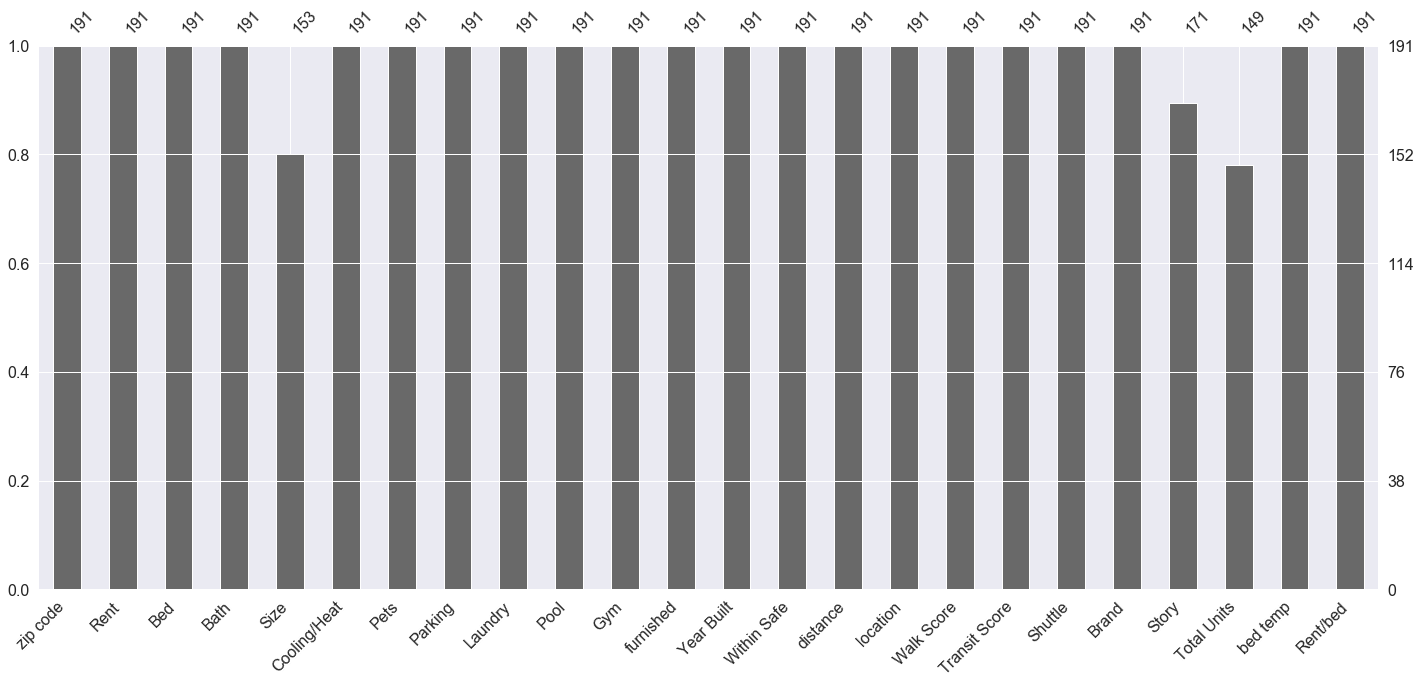

In [25]:
msno.bar(df_train)                   # 柱状图

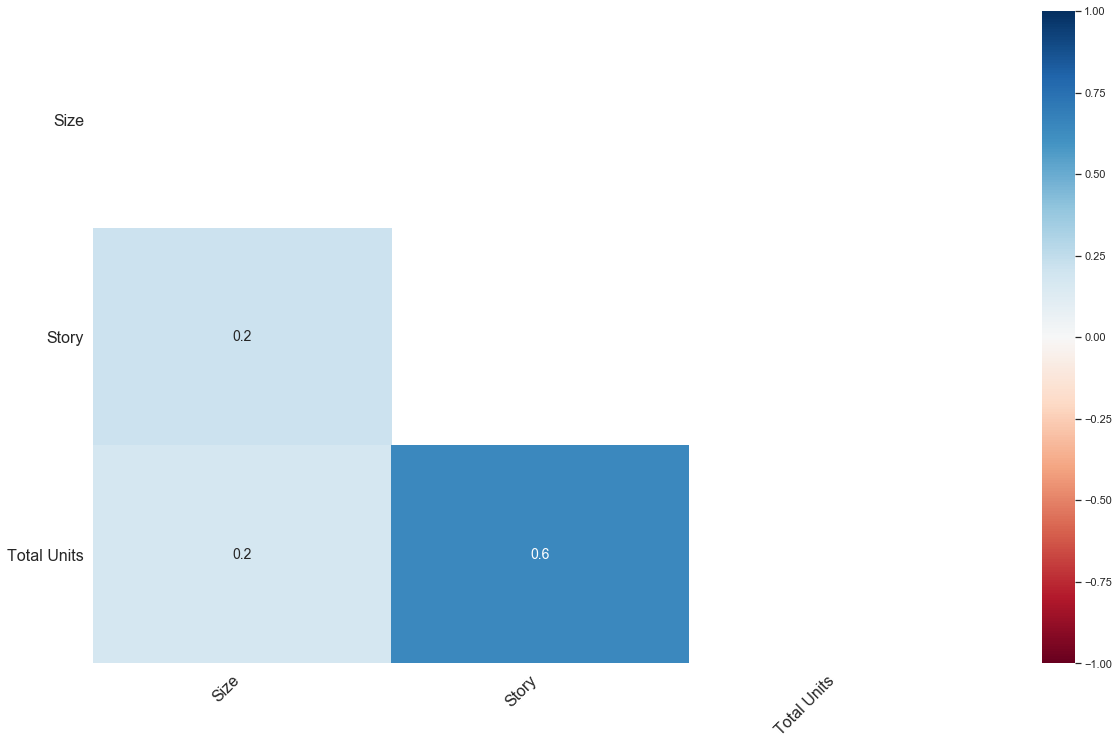

In [26]:
msno.heatmap(df_train)               # 热力图

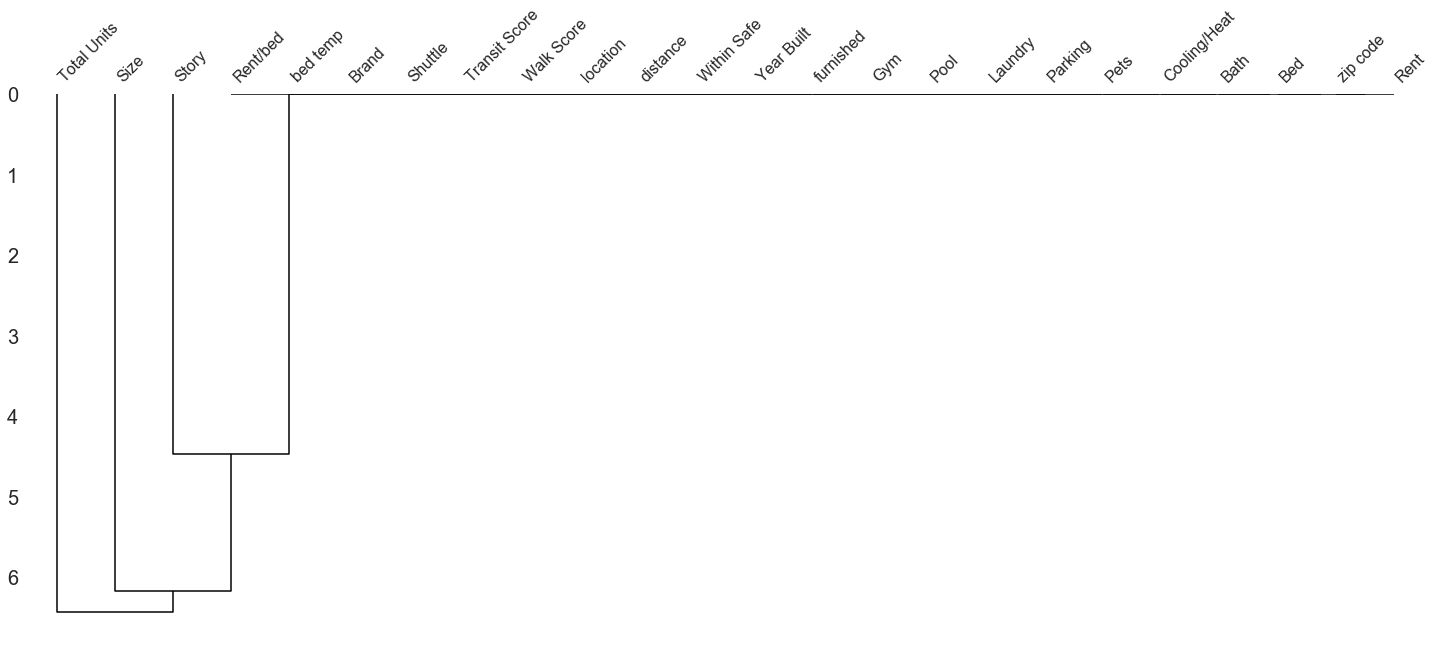

In [27]:
msno.dendrogram(df_train)

In [28]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Total Units,42,0.219895
Size,38,0.198953
Story,20,0.104712
Rent/bed,0,0.000000
Gym,0,0.000000
Rent,0,0.000000
Bed,0,0.000000
Bath,0,0.000000
Cooling/Heat,0,0.000000
Pets,0,0.000000


In [29]:
df_train.groupby(['Bed','Bath'])['Size'].median()

Bed  Bath
0.5  1.0     400.000000
1.0  1.0     650.000000
2.0  1.0     398.750000
     1.5     500.000000
     2.0     478.000000
     2.5     562.500000
3.0  1.0     350.000000
     1.5     333.333333
     2.0     444.166667
     2.5            NaN
     3.0     416.416667
     3.5     533.333333
4.0  1.0            NaN
     2.0     433.250000
     4.0     362.500000
5.0  2.0            NaN
     4.0     460.000000
     5.0     350.000000
6.0  2.0            NaN
     4.0     183.333333
     5.0            NaN
     6.0     391.666667
7.0  3.0     444.428571
     7.0     250.000000
Name: Size, dtype: float64

In [30]:
df_train['Size'] = df_train.groupby("Bed")["Size"].transform(lambda x: x.fillna(x.mean()))

In [31]:
df_train['Story'] = df_train['Story'].fillna(df_train['Story'].mode()[0])

In [32]:
df_train.drop(columns=['Total Units'],inplace=True)

In [33]:
df_train.shape

(191, 23)

In [34]:
df_train.isnull().sum().sort_values(ascending=False)

Rent/bed         0
Gym              0
Rent             0
Bed              0
Bath             0
Size             0
Cooling/Heat     0
Pets             0
Parking          0
Laundry          0
Pool             0
furnished        0
bed temp         0
Year Built       0
Within Safe      0
distance         0
location         0
Walk Score       0
Transit Score    0
Shuttle          0
Brand            0
Story            0
zip code         0
dtype: int64

# Categorical Data

In [35]:
cols = ['zip code','Laundry','Year Built','location']

## One-Hot (Dummy) 

In [36]:
all_dummies = pd.get_dummies(df_train[cols], prefix_sep='_')#, drop_first=True)


In [37]:
df_train_dummy = pd.concat([df_train.drop(columns=cols), all_dummies], axis=1)

In [38]:
#df_train['location'].unique()
df_train_dummy

,Rent,Bed,Bath,Size,Cooling/Heat,Pets,Parking,Pool,Gym,furnished,...,Laundry_in,Laundry_share,Year Built_new,Year Built_old,location_N,location_NE,location_NW,location_SE,location_SW,location_W
0,1600,0.5,1.0,400.000000,1,0,1,1,0,0,...,0,1,0,1,1,0,0,0,0,0
1,1800,0.5,1.0,475.000000,1,0,1,1,0,0,...,0,1,0,1,1,0,0,0,0,0
2,2200,1.0,1.0,650.000000,1,0,1,1,0,0,...,0,1,0,1,1,0,0,0,0,0
3,3200,2.0,2.0,478.000000,1,0,1,1,0,0,...,0,1,0,1,1,0,0,0,0,0
4,1895,2.0,1.0,212.500000,1,0,0,0,0,1,...,1,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2495,2.0,1.0,357.500000,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
188,2650,3.0,1.0,350.000000,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
189,6200,3.0,3.0,436.166667,1,0,1,1,1,1,...,1,0,1,0,0,1,0,0,0,0
190,4200,2.0,2.0,573.000000,1,0,1,1,1,1,...,1,0,1,0,0,1,0,0,0,0


In [39]:
df_train.head()

,zip code,Rent,Bed,Bath,Size,Cooling/Heat,Pets,Parking,Laundry,Pool,...,Within Safe,distance,location,Walk Score,Transit Score,Shuttle,Brand,Story,bed temp,Rent/bed
0,90007,1600,0.5,1.0,400.0,1,0,1,share,1,...,1,0.5,N,88,82,1,0,3.0,1.0,1600.0
1,90007,1800,0.5,1.0,475.0,1,0,1,share,1,...,1,0.5,N,88,82,1,0,3.0,1.0,1800.0
2,90007,2200,1.0,1.0,650.0,1,0,1,share,1,...,1,0.5,N,88,82,1,0,3.0,1.0,2200.0
3,90007,3200,2.0,2.0,478.0,1,0,1,share,1,...,1,0.5,N,88,82,1,0,3.0,2.0,1600.0
4,90007,1895,2.0,1.0,212.5,1,0,0,in,0,...,1,0.4,N,85,68,0,0,2.0,2.0,947.5


## LabelEncoder

from sklearn.preprocessing import LabelEncoder
df_train_LE = df_train.copy()
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_train_LE[c].values)) 
    df_train_LE[c] = lbl.transform(list(df_train_LE[c].values))

In [40]:
df_train_LE = df_train.copy()

df_train_LE['Laundry'].loc[df_train_LE['Laundry'] == 'in'] = 1
df_train_LE['Laundry'].loc[df_train_LE['Laundry'] == 'share'] = 0

df_train_LE['Year Built'].loc[df_train_LE['Year Built'] == 'new'] = 1
df_train_LE['Year Built'].loc[df_train_LE['Year Built'] == 'old'] = 0

df_train_LE['location'].loc[df_train_LE['location'] == 'NE'] = 6
df_train_LE['location'].loc[df_train_LE['location'] == 'N'] = 5
df_train_LE['location'].loc[df_train_LE['location'] == 'SE'] = 4
df_train_LE['location'].loc[df_train_LE['location'] == 'W'] = 3 
df_train_LE['location'].loc[df_train_LE['location'] == 'NW'] = 2
df_train_LE['location'].loc[df_train_LE['location'] == 'SW'] = 1

df_train_LE['zip code'].loc[df_train_LE['zip code'] == '90007'] = 4
df_train_LE['zip code'].loc[df_train_LE['zip code'] == '90018'] = 3
df_train_LE['zip code'].loc[df_train_LE['zip code'] == '90037'] = 2
df_train_LE['zip code'].loc[df_train_LE['zip code'] == '90062'] = 1

df_train_LE['location score'] = df_train_LE['location'] + df_train_LE['zip code'] + df_train_LE['Within Safe']



In [41]:
df_train_LE['Laundry'] = df_train_LE['Laundry'].astype(int)
df_train_LE['zip code'] = df_train_LE['zip code'].astype(int)
df_train_LE['Year Built'] = df_train_LE['Year Built'].astype(int)
df_train_LE['location'] = df_train_LE['location'].astype(int)
df_train_LE['location score'] = df_train_LE['location score'].astype(int)
df_train_LE.dtypes

zip code            int64
Rent                int64
Bed               float64
Bath              float64
Size              float64
Cooling/Heat        int64
Pets                int64
Parking             int64
Laundry             int64
Pool                int64
Gym                 int64
furnished           int64
Year Built          int64
Within Safe         int64
distance          float64
location            int64
Walk Score          int64
Transit Score       int64
Shuttle             int64
Brand               int64
Story             float64
bed temp          float64
Rent/bed          float64
location score      int64
dtype: object

In [42]:
#df_train_LE = df_train.copy()

df_train_LE

,zip code,Rent,Bed,Bath,Size,Cooling/Heat,Pets,Parking,Laundry,Pool,...,distance,location,Walk Score,Transit Score,Shuttle,Brand,Story,bed temp,Rent/bed,location score
0,4,1600,0.5,1.0,400.000000,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,1.0,1600.000000,10
1,4,1800,0.5,1.0,475.000000,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,1.0,1800.000000,10
2,4,2200,1.0,1.0,650.000000,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,1.0,2200.000000,10
3,4,3200,2.0,2.0,478.000000,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,2.0,1600.000000,10
4,4,1895,2.0,1.0,212.500000,1,0,0,1,0,...,0.4,5,85,68,0,0,2.0,2.0,947.500000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,4,2495,2.0,1.0,357.500000,0,0,1,1,0,...,0.3,3,75,67,0,0,2.0,2.0,1247.500000,8
188,4,2650,3.0,1.0,350.000000,0,0,1,1,0,...,0.3,3,75,67,0,0,2.0,3.0,883.333333,8
189,4,6200,3.0,3.0,436.166667,1,0,1,1,1,...,0.9,6,91,91,1,2,6.0,3.0,2066.666667,11
190,4,4200,2.0,2.0,573.000000,1,0,1,1,1,...,0.9,6,91,91,1,2,6.0,2.0,2100.000000,11


# Analysis Rent

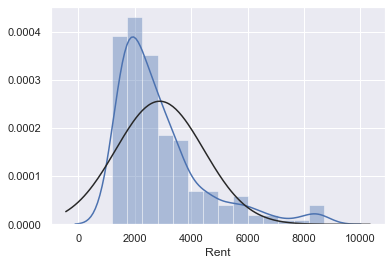

In [43]:
sns.distplot(df_train['Rent'], fit=norm)

In [44]:
#skewness and kurtosis
print("Skewness: %f" % df_train['Rent'].skew())
print("Kurtosis: %f" % df_train['Rent'].kurt())

Skewness: 1.729888
Kurtosis: 3.022274


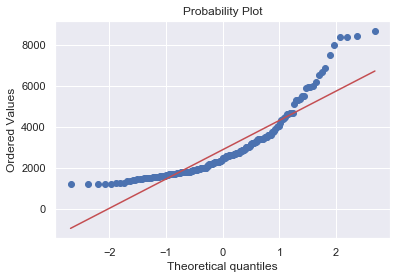

In [45]:
fig = plt.figure()
res = stats.probplot(df_train['Rent'], plot=plt)
plt.show()

In [46]:
df_train_dummy['Rent'] = np.log1p(df_train_dummy['Rent'])
df_train_LE['Rent'] = np.log1p(df_train_LE['Rent'])

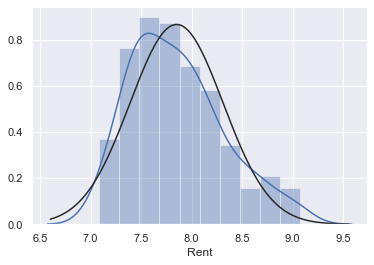

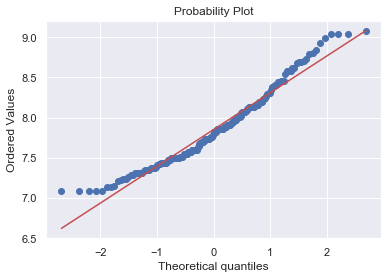

In [47]:
#transformed histogram and normal probability plot
sns.distplot(df_train_LE['Rent'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train_LE['Rent'], plot=plt)


In [48]:
#skewness and kurtosis
print("Skewness: %f" % df_train_LE['Rent'].skew())
print("Kurtosis: %f" % df_train_LE['Rent'].kurt())

Skewness: 0.634857
Kurtosis: -0.126746


In [49]:
df_train_LE.head()

,zip code,Rent,Bed,Bath,Size,Cooling/Heat,Pets,Parking,Laundry,Pool,...,distance,location,Walk Score,Transit Score,Shuttle,Brand,Story,bed temp,Rent/bed,location score
0,4,7.378384,0.5,1.0,400.0,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,1.0,1600.0,10
1,4,7.496097,0.5,1.0,475.0,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,1.0,1800.0,10
2,4,7.696667,1.0,1.0,650.0,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,1.0,2200.0,10
3,4,8.071219,2.0,2.0,478.0,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,2.0,1600.0,10
4,4,7.547502,2.0,1.0,212.5,1,0,0,1,0,...,0.4,5,85,68,0,0,2.0,2.0,947.5,10


In [50]:
df_train_LE['Rent']

0      7.378384
1      7.496097
2      7.696667
3      8.071219
4      7.547502
         ...   
187    7.822445
188    7.882692
189    8.732466
190    8.343078
191    7.901377
Name: Rent, Length: 191, dtype: float64

# Feature Selection

In [51]:
features = df_train_LE[['zip code', 'Bed', 'Bath', 'Size', 'Cooling/Heat', 'Pets',
       'Parking', 'Laundry', 'Pool', 'Gym', 'furnished', 'Year Built',
       'Within Safe', 'distance', 'location', 'Walk Score', 'Transit Score',
       'Shuttle', 'Brand', 'Story','location score']]

In [52]:
train_label = df_train_LE['Rent']

In [53]:
from sklearn.feature_selection import SelectKBest, f_regression
fr = SelectKBest(score_func=f_regression, k=18)
new = fr.fit_transform(features,train_label)
selected_features = features.columns[fr.get_support()]
selected_features

Index(['Bed', 'Bath', 'Size', 'Cooling/Heat', 'Parking', 'Laundry', 'Pool',
       'Gym', 'furnished', 'Year Built', 'Within Safe', 'distance', 'location',
       'Walk Score', 'Transit Score', 'Shuttle', 'Brand', 'Story'],
      dtype='object')

# Normalization

from sklearn.preprocessing import StandardScaler


ss = StandardScaler()

df_train[['Rent', 'Size', 'distance', 'Walk Score', 'Transit Score']] = ss.fit_transform(df_train[['Rent', 'Size', 'distance', 'Walk Score', 'Transit Score']])


df_train

# Train Model

## Split Train / Test

In [54]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle

In [55]:
def data_split(train_data, train_feature_cols):
    train_label = train_data['Rent']
    train_features = train_data[train_feature_cols]
    X,y = shuffle(train_features, train_label, random_state = 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
    
    return X_train, y_train, X_test, y_test, X, y 
    

#train_features = df_train[selected_features]
train_features = df_train[['Bed', 'Bath', 'Size', 'Cooling/Heat', 'Pets', 'Parking',
       'Pool', 'Gym', 'furnished', 'Within Safe', 'walk to USC', 'distance',
       'Walk Score', 'Transit Score', 'Shuttle', 'Brand', 'Story',
       'zip code_90007', 'zip code_90018', 'zip code_90037',
       'zip code_90062', 'Laundry_in', 'Laundry_share', 'Year Built_new',
       'Year Built_old', 'location_N', 'location_NE', 'location_NW',
       'location_SE', 'location_SW', 'location_W']]

train_features.head()

train_label.head()

X,y = shuffle(train_features, train_label, random_state = 0)

X.head()

y.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import Lasso

In [57]:
def regression_model(X_tr, y_tr, X_t, y_t, X1, y1):
    #Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_tr, y_tr)
    lr_y_pred = lr_model.predict(X_t)
    lr_y_train_pred = lr_model.predict(X_tr)
    print("Linear Regression Result")
    print("Train R2: {}".format(r2_score(y_tr, lr_y_train_pred)))
    print("Test R2: {}".format(r2_score(y_t, lr_y_pred)))
    print('MAE: {}'.format(mean_absolute_error(y_t, lr_y_pred)))
    print("Cross Validation Score: {}\n".format(cross_val_score(lr_model, X1, y1, cv=5).mean()))
    
    #Elastic Net
    EN_model = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99])
    EN_model.fit(X_tr, y_tr)
    EN_y_pred = EN_model.predict(X_t)
    print("Elastic Net Result")
    print("R2: {}".format(r2_score(y_t, EN_y_pred)))
    print('MAE: {}'.format(mean_absolute_error(y_t, EN_y_pred)))
    print("Cross Validation Score: {}\n".format(cross_val_score(EN_model, X1, y1, cv=5).mean()))
    
    #Lasso Regression
    lasso = Lasso(alpha=0.0005)
    lasso.fit(X_tr, y_tr)
    lasso_y_pred = lasso.predict(X_t)
    print("Lasso")
    print("R2: {}".format(r2_score(y_t, lasso_y_pred)))
    print('MAE: {}'.format(mean_absolute_error(y_t, lasso_y_pred)))
    print("Cross Validation Score: {}".format(cross_val_score(lasso, X1, y1, cv=5).mean()))

In [58]:
LE_cols = ['zip code', 'Bed', 'Bath', 'Size', 'Cooling/Heat', 'Pets',
       'Parking', 'Laundry', 'Pool', 'Gym', 'furnished', 'Year Built',
       'Within Safe', 'distance', 'location', 'Walk Score', 'Transit Score',
       'Shuttle', 'Brand', 'Story', 'location score']
LE_X_train,LE_y_train, LE_X_test, LE_y_test, X, y = data_split(df_train_LE, LE_cols)

In [59]:
regression_model(LE_X_train, LE_y_train, LE_X_test, LE_y_test, X, y) 

Linear Regression Result
Train R2: 0.8408700184625094
Test R2: 0.8131515413339694
MAE: 0.14133119779353934
Cross Validation Score: 0.7641186699410241

Elastic Net Result
R2: 0.8392146616309398
MAE: 0.12486964691258216
Cross Validation Score: 0.7773335164412755

Lasso
R2: 0.8226401686639282
MAE: 0.13767086910881207
Cross Validation Score: 0.7692294255915706


In [60]:
dummy_cols = ['Bed', 'Bath', 'Size', 'Cooling/Heat', 'Pets', 'Parking',
       'Pool', 'Gym', 'furnished', 'Within Safe', 'distance', 'Walk Score',
       'Transit Score', 'Shuttle', 'Brand', 'Story', 'zip code_90007',
       'zip code_90018', 'zip code_90037', 'zip code_90062', 'Laundry_in',
       'Laundry_share', 'Year Built_new', 'Year Built_old', 'location_N',
       'location_NE', 'location_NW', 'location_SE', 'location_SW',
       'location_W']
dummy_X_train, dummy_X_test, dummy_y_train, dummy_y_test, X, y = data_split(df_train_dummy, dummy_cols)

In [61]:
regression_model(dummy_X_train, dummy_X_test, dummy_y_train, dummy_y_test, X, y)

Linear Regression Result
Train R2: 0.8652023644624024
Test R2: 0.5934008675197181
MAE: 0.1694566579409327
Cross Validation Score: 0.7380592371867727

Elastic Net Result
R2: 0.8314065391480153
MAE: 0.13064359149595114
Cross Validation Score: 0.7773803738345437

Lasso
R2: 0.664996465476939
MAE: 0.15920549580900842
Cross Validation Score: 0.755677758379119


## KNN

from sklearn.neighbors import KNeighborsRegressor


### Using dummy

k_range = range(1, 31)
k_score = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5)
    k_score.append(scores.mean())

plt.plot(k_range, k_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('CV Score')
plt.show()

# Gradient Boosting

In [62]:
df_train['Laundry'].loc[df_train['Laundry'] == 'in'] = 1
df_train['Laundry'].loc[df_train['Laundry'] == 'share'] = 0

df_train['Year Built'].loc[df_train['Year Built'] == 'new'] = 1
df_train['Year Built'].loc[df_train['Year Built'] == 'old'] = 0

df_train['location'].loc[df_train['location'] == 'NE'] = 6
df_train['location'].loc[df_train['location'] == 'N'] = 5
df_train['location'].loc[df_train['location'] == 'SE'] = 4
df_train['location'].loc[df_train['location'] == 'W'] = 3 
df_train['location'].loc[df_train['location'] == 'NW'] = 2
df_train['location'].loc[df_train['location'] == 'SW'] = 1

df_train['zip code'].loc[df_train['zip code'] == '90007'] = 4
df_train['zip code'].loc[df_train['zip code'] == '90018'] = 3
df_train['zip code'].loc[df_train['zip code'] == '90037'] = 2
df_train['zip code'].loc[df_train['zip code'] == '90062'] = 1

df_train['location score'] = df_train['location'] + df_train['zip code'] + df_train['Within Safe']

In [63]:
df_train['Laundry'] = df_train['Laundry'].astype(int)
df_train['zip code'] = df_train['zip code'].astype(int)
df_train['Year Built'] = df_train['Year Built'].astype(int)
df_train['location'] = df_train['location'].astype(int)
df_train['location score'] = df_train['location score'].astype(int)
df_train.dtypes

zip code            int64
Rent                int64
Bed               float64
Bath              float64
Size              float64
Cooling/Heat        int64
Pets                int64
Parking             int64
Laundry             int64
Pool                int64
Gym                 int64
furnished           int64
Year Built          int64
Within Safe         int64
distance          float64
location            int64
Walk Score          int64
Transit Score       int64
Shuttle             int64
Brand               int64
Story             float64
bed temp          float64
Rent/bed          float64
location score      int64
dtype: object

In [64]:
df_train.head()

,zip code,Rent,Bed,Bath,Size,Cooling/Heat,Pets,Parking,Laundry,Pool,...,distance,location,Walk Score,Transit Score,Shuttle,Brand,Story,bed temp,Rent/bed,location score
0,4,1600,0.5,1.0,400.0,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,1.0,1600.0,10
1,4,1800,0.5,1.0,475.0,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,1.0,1800.0,10
2,4,2200,1.0,1.0,650.0,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,1.0,2200.0,10
3,4,3200,2.0,2.0,478.0,1,0,1,0,1,...,0.5,5,88,82,1,0,3.0,2.0,1600.0,10
4,4,1895,2.0,1.0,212.5,1,0,0,1,0,...,0.4,5,85,68,0,0,2.0,2.0,947.5,10


In [65]:
c = [ 'Bed', 'Bath', 'Size', 'Cooling/Heat', 
       'Parking', 'Pool', 'Gym', 'furnished', 'Year Built', 
        'distance',  'Walk Score', 'Transit Score',
       'Brand', 'Story', 'location score']
X_train, y_train, X_test, y_test, X, y = data_split(df_train, c)

[2.49932033e-01 5.08677382e-01 2.08831360e-02 5.08448461e-02
 2.00723389e-03 4.78934794e-04 1.80726978e-02 4.71382535e-03
 5.46410575e-03 2.17198690e-02 1.96213193e-02 1.39088568e-02
 1.69383191e-02 4.35823200e-02 2.31551210e-02]


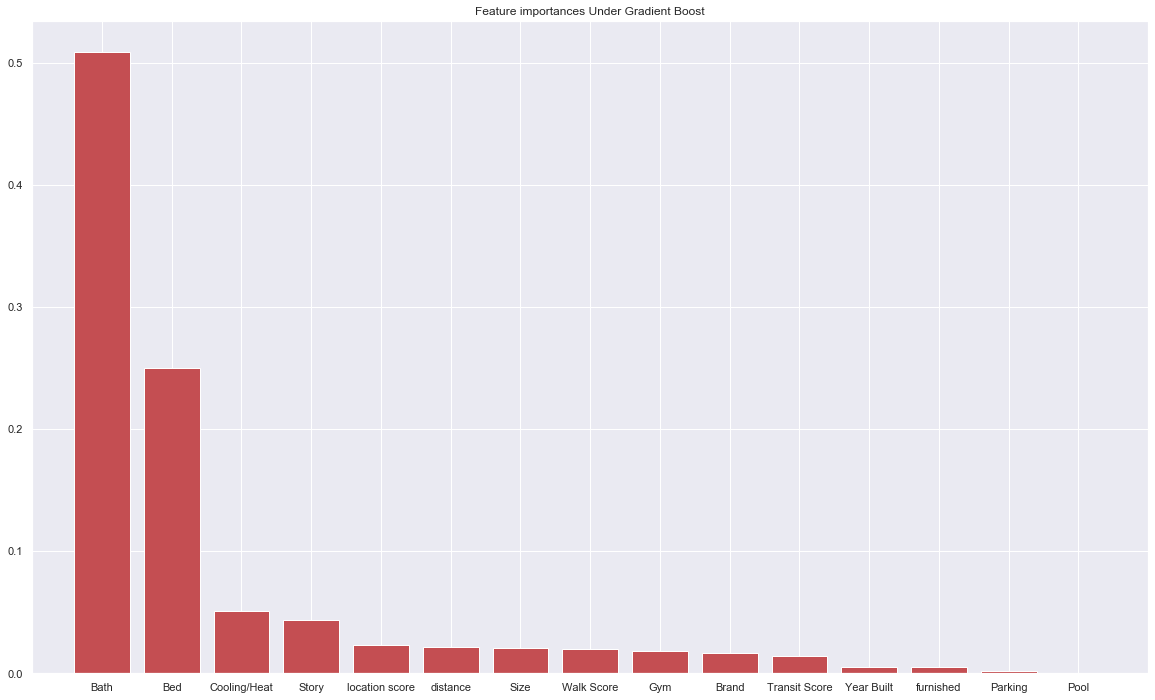

In [66]:
from sklearn import ensemble
GBest = ensemble.GradientBoostingRegressor(n_estimators=100)
GBest.fit(X_train, y_train)
print(GBest.feature_importances_)

importances = GBest.feature_importances_
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
plt.figure(figsize=(20,12))
plt.title("Feature importances Under Gradient Boost")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [67]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=230,learning_rate=0.099, loss='huber', random_state=9
                                          ,max_depth=3)
GBest.fit(X_train, y_train)
GBest_y_pred = GBest.predict(X_test)
print("Train Score: {}".format(GBest.score(X_train, y_train)))
print("Test Score: {}".format(GBest.score(X_test, y_test)))
#print("R2: {}".format(r2_score(y_test, GBest_y_pred)))
print('MAE: {}'.format(mean_absolute_error(y_test, GBest_y_pred)))
print("Cross Validation Score: {}".format(cross_val_score(GBest, X, y, cv=6).mean()))

Train Score: 0.9910286645293562
Test Score: 0.9184700294414013
MAE: 257.7708552946865
Cross Validation Score: 0.7980013297601074


# Random Forest

[2.07253828e-01 5.46428070e-01 5.09674300e-02 1.00133738e-02
 3.42510906e-03 5.16648674e-04 1.50047496e-02 1.22983002e-02
 3.50451926e-03 2.39197510e-02 2.65709042e-02 2.24747976e-02
 2.06871298e-02 4.24626501e-02 1.44727384e-02]


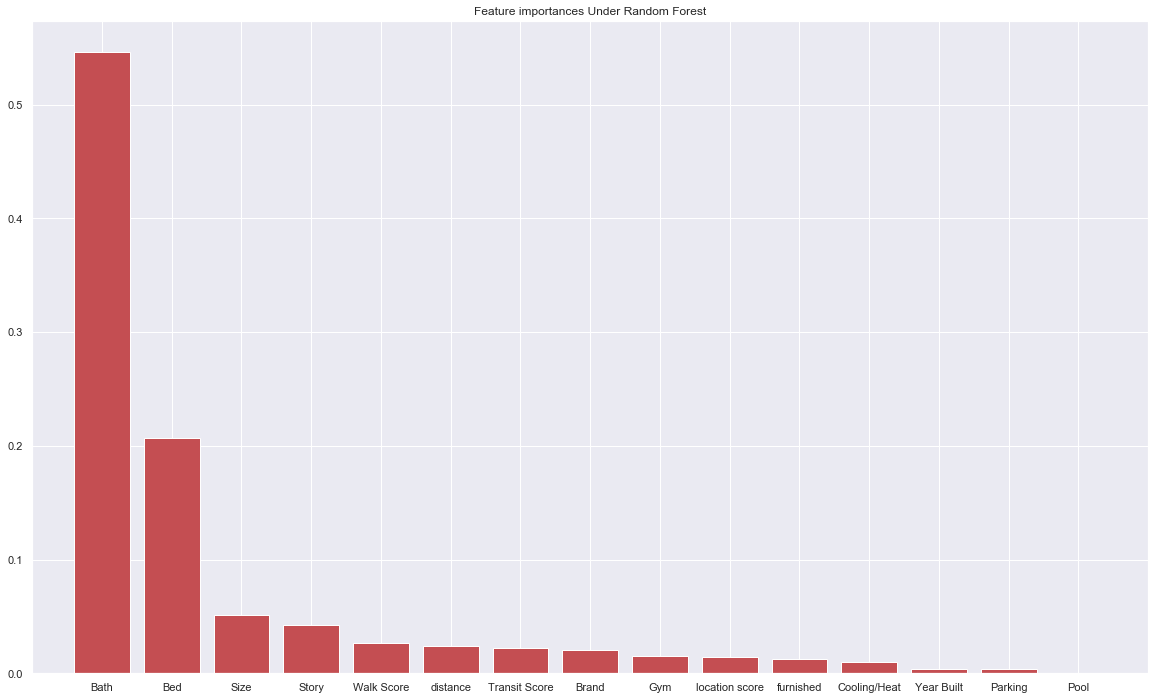

In [68]:
rfr = ensemble.RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
print(rfr.feature_importances_)

importancesrf = rfr.feature_importances_
indicesrf = np.argsort(importancesrf)[::-1]
# Plot the feature importances of the forest
plt.figure(figsize=(20,12))
plt.title("Feature importances Under Random Forest")
plt.bar(range(X_train.shape[1]), importancesrf[indicesrf],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indicesrf])
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [69]:
rfr = ensemble.RandomForestRegressor(n_estimators=500, max_depth=10, max_features=3, random_state=7)
rfr.fit(X_train, y_train)
rfr_y_pred = rfr.predict(X_test)
print("Train Score: {}".format(rfr.score(X_train, y_train)))
print("Test Score: {}".format(rfr.score(X_test, y_test)))
#print("R2: {}".format(r2_score(y_test, GBest_y_pred)))
print('MAE: {}'.format(mean_absolute_error(y_test, rfr_y_pred)))
print("Cross Validation Score: {}".format(cross_val_score(rfr, X, y, cv=5).mean()))

Train Score: 0.9608917170766186
Test Score: 0.8242433834998885
MAE: 334.6679578222781
Cross Validation Score: 0.7759238318877261


# XGBoost

In [70]:
df_train_xgb
df_train_xgb['Laundry'].loc[df_train_xgb['Laundry'] == 'in'] = 1
df_train_xgb['Laundry'].loc[df_train_xgb['Laundry'] == 'share'] = 0

df_train_xgb['Year Built'].loc[df_train_xgb['Year Built'] == 'new'] = 1
df_train_xgb['Year Built'].loc[df_train_xgb['Year Built'] == 'old'] = 0

df_train_xgb['location'].loc[df_train_xgb['location'] == 'NE'] = 6
df_train_xgb['location'].loc[df_train_xgb['location'] == 'N'] = 5
df_train_xgb['location'].loc[df_train_xgb['location'] == 'SE'] = 4
df_train_xgb['location'].loc[df_train_xgb['location'] == 'W'] = 3 
df_train_xgb['location'].loc[df_train_xgb['location'] == 'NW'] = 2
df_train_xgb['location'].loc[df_train_xgb['location'] == 'SW'] = 1

df_train_xgb['zip code'].loc[df_train_xgb['zip code'] == '90007'] = 4
df_train_xgb['zip code'].loc[df_train_xgb['zip code'] == '90018'] = 3
df_train_xgb['zip code'].loc[df_train_xgb['zip code'] == '90037'] = 2
df_train_xgb['zip code'].loc[df_train_xgb['zip code'] == '90062'] = 1

df_train_xgb['location score'] = df_train_xgb['location'] + df_train_xgb['zip code'] + df_train_xgb['Within Safe']

In [71]:
df_train_xgb['Laundry'] = df_train_xgb['Laundry'].astype(int)
df_train_xgb['zip code'] = df_train_xgb['zip code'].astype(int)
df_train_xgb['Year Built'] = df_train_xgb['Year Built'].astype(int)
df_train_xgb['location'] = df_train_xgb['location'].astype(int)
df_train_xgb['location score'] = df_train_xgb['location score'].astype(int)
df_train_xgb.dtypes

zip code            int64
Rent                int64
Bed               float64
Bath              float64
Size              float64
Cooling/Heat        int64
Pets                int64
Parking             int64
Laundry             int64
Pool                int64
Gym                 int64
furnished           int64
Year Built          int64
Within Safe         int64
distance          float64
location            int64
Walk Score          int64
Transit Score       int64
Shuttle             int64
Brand               int64
Story             float64
Total Units       float64
bed temp          float64
Rent/bed          float64
location score      int64
dtype: object

In [72]:
c = [ 'Bed', 'Bath', 'Size', 'Cooling/Heat', 
       'Parking', 'Pool', 'Gym', 'furnished', 'Year Built', 
        'distance',  'Walk Score', 'Transit Score',
       'Brand', 'Story']
X_train, y_train, X_test, y_test, X, y = data_split(df_train_xgb, c)

In [73]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective= 'reg:squarederror', 
                   learning_rate=0.099,    #含义：学习率，控制每次迭代更新权重时的步长，默认0.3。调参：值越小，训练越慢。典型值为0.01-0.2。
                  n_estimators=273,       #含义：总共迭代的次数，即决策树的个数
                  max_depth=2,           #含义：树的深度，默认值为6，典型值3-10。调参：值越大，越容易过拟合；值越小，越容易欠拟合
                  gamma=1,               #含义：惩罚项系数，指定节点分裂所需的最小损失函数下降值。
                  subsample=1,       #含义：训练每棵树时，使用的数据占全部训练集的比例。默认值为1，典型值为0.5-1。调参：防止overfitting。
                  colsample_bytree=1,
                   random_state=8)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("Train Score: {}".format(xgb.score(X_train, y_train)))
print("Test Score: {}".format(xgb.score(X_test, y_test)))
#print("R2: {}".format(r2_score(y_test, GBest_y_pred)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print("Cross Validation Score: {}".format(cross_val_score(xgb, X, y, cv=6).mean()))

Train Score: 0.9851069151833088
Test Score: 0.9358016217269225
MAE: 256.060557830028
Cross Validation Score: 0.8613819504821669


# Ensemble Modeling

In [74]:
c = [ 'Bed', 'Bath', 'Size', 'Cooling/Heat', 
       'Parking', 'Pool', 'Gym', 'furnished', 'Year Built', 
        'distance',  'Walk Score', 'Transit Score',
       'Brand']
X_train, y_train, X_test, y_test, X, y = data_split(df_train, c)

In [75]:

votingC = ensemble.VotingRegressor(estimators=[('XGB', xgb),('gbc',GBest)],  n_jobs=4)
votingC.fit(X_train, y_train)
y_pred = votingC.predict(X_test)

print("Train Score: {}".format(votingC.score(X_train, y_train)))
print("Test Score: {}".format(votingC.score(X_test, y_test)))
#print("R2: {}".format(r2_score(y_test, GBest_y_pred)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print("Cross Validation Score: {}".format(cross_val_score(votingC, X, y, cv=6).mean()))

Train Score: 0.9889869678446777
Test Score: 0.9396685677353477
MAE: 223.28675568839927
Cross Validation Score: 0.8359192286919517


In [76]:
votingC.predict(X_train.iloc[:5])

array([3115.51471751, 1756.2418685 , 3085.2204693 , 1417.32166817,
       1866.19501597])

In [77]:
X_real = X_train.iloc[:5].copy()
X_real['Bed'].iloc[0] =6
X_real['Bath'].iloc[0] = 6
X_real['Size'].iloc[0] = 1408
X_real['furnished'].iloc[0] = 1
X_real['distance'].iloc[0] = 1
X_real['Walk Score'].iloc[0] = 83
X_real['Transit Score'].iloc[0] = 60
X_real['Brand'].iloc[0] = 1

X_real['Bed'].iloc[1] =4
X_real['Bath'].iloc[1] = 4
X_real['Size'].iloc[1] = 1029.75
X_real['furnished'].iloc[1] = 1
X_real['distance'].iloc[1] = 1
X_real['Walk Score'].iloc[1] = 83
X_real['Transit Score'].iloc[1] = 60
X_real['Brand'].iloc[1] = 1
X_real['Year Built'].iloc[1] = 1


X_real['Bed'].iloc[2] =2
X_real['Bath'].iloc[2] = 2.5
X_real['Size'].iloc[2] = 1125
X_real['furnished'].iloc[2] = 0
X_real['distance'].iloc[2] = 0.3
X_real['Walk Score'].iloc[2] = 88
X_real['Transit Score'].iloc[2] = 67
X_real['Brand'].iloc[2] = 0
X_real['Year Built'].iloc[2] = 1

In [78]:
X_real

,Bed,Bath,Size,Cooling/Heat,Parking,Pool,Gym,furnished,Year Built,distance,Walk Score,Transit Score,Brand
82,6.0,6.0,1408.00,1,1,0,0,1,1,1.0,83,60,1
44,4.0,4.0,1029.75,1,1,0,0,1,1,1.0,83,60,1
96,2.0,2.5,1125.00,1,1,0,0,0,1,0.3,88,67,0
12,0.5,1.0,275.00,1,1,0,0,0,0,0.7,91,67,1
51,1.0,1.0,520.00,1,1,0,0,0,0,0.8,90,77,0


In [79]:
votingC.predict(X_real)

array([7154.56789759, 5821.76801603, 3224.01534212, 1417.32166817,
       1866.19501597])

In [80]:
(7154.56789759+223.28675568839927)/6

1229.6424422130665

In [81]:
(7154.56789759-223.28675568839927)/6

1155.2135236502668

In [82]:
(5821.76801603+223.28675568839927)/4 

1511.2636929295998

In [83]:
(5821.76801603-223.28675568839927)/4 

1399.6203150854

In [84]:
def data_split1(train_data, train_feature_cols, n):
    train_label = train_data['Rent']
    train_features = train_data[train_feature_cols]
    X,y = shuffle(train_features, train_label, random_state = 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=n) 
    
    return X_train, y_train, X_test, y_test, X, y 

In [85]:
AE = []
c = [ 'Bed', 'Bath', 'Size', 'Cooling/Heat', 
       'Parking', 'Pool', 'Gym', 'furnished', 'Year Built', 
        'distance',  'Walk Score', 'Transit Score',
       'Brand']
for i in range(50,70):
    X_train1, y_train1, X_test1, y_test1, X1, y1 = data_split1(df_train, c, i)
    votingC = ensemble.VotingRegressor(estimators=[('XGB', xgb),('gbc',GBest)],  n_jobs=4)
    votingC.fit(X_train1, y_train1)
    y_pred = votingC.predict(X_test1)
    X_test1['Bed'].loc[X_test1['Bed']==0.5]=1
    AE.append(np.mean(abs(y_pred - y_test1) /  X_test1['Bed']))

In [86]:
np.mean(AE)

204.12618814377612

In [87]:
res = pd.DataFrame()
for i in range(50,60):
    X_train1, y_train1, X_test1, y_test1, X1, y1 = data_split1(df_train, c, i)
    votingC = ensemble.VotingRegressor(estimators=[('XGB', xgb),('gbc',GBest)],  n_jobs=4)
    votingC.fit(X_train1, y_train1)
    y_pred = votingC.predict(X_test1)
    X_test1['Error'] = abs(y_pred - y_test1)
    X_test1.groupby('Bed')['Error'].mean()
    temp = pd.DataFrame(data=X_test1.groupby('Bed')['Error'].mean())
    result = pd.concat([res, temp], axis=1, sort=False)
result
#AE.append(np.mean(abs(y_pred - y_test1) /  X_test1['Bed']))

,Error
Bed,
0.5,105.729925
1.0,269.170153
2.0,234.696182
3.0,290.052714
4.0,1019.801755
5.0,1026.561348


c = [ 'Bed', 'Bath', 'Size', 'Cooling/Heat', 
       'Parking', 'Pool', 'Gym', 'furnished', 'Year Built', 
        'distance',  'Walk Score', 'Transit Score',
       'Brand']
X_train1, y_train1, X_test1, y_test1, X1, y1 = data_split1(df_train, c)

votingC = ensemble.VotingRegressor(estimators=[('XGB', xgb),('gbc',GBest)],  n_jobs=4)
votingC.fit(X_train1, y_train1)
y_pred = votingC.predict(X_test1)

X_test1

np.mean(abs(y_pred - y_test1) /  X_test1['Bed'])

mean_absolute_error(y_test1, y_pred)

## Linear Regression

from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
def XGBooster(param_grid):
    estimator = XGBRegressor()
    cross_validator = KFold(n_splits=5,shuffle=True) 
    classifier = GridSearchCV(estimator=estimator, cv=cross_validator, param_grid=param_grid,verbose=1, n_jobs=4) 
    classifier.fit(X_train, y_train)
    print("Best Estimator learned through GridSearch") 
    print( classifier.best_estimator_ )
    return cross_validator, classifier.best_estimator_ 

param_grid={'n_estimators': [300, 400, 500, 600, 700, 800], 
            'learning_rate': [0.1, 0.09, 0.07, 0.05, 0.02, 0.01], 
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
            'min_child_weight': [1, 2, 3, 4, 5, 6],
            'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
            'subsample': [0.6, 0.7, 0.8, 0.9], 
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
           } 


XGBooster(param_grid)

from sklearn.preprocessing import PolynomialFeatures

for i in range(10):
    poly = PolynomialFeatures(degree=i)
    X_poly = poly.fit_transform(LE_X_train)
    X_test_poly = poly.fit_transform(LE_X_test)
    linreg = LinearRegression().fit(X_poly, LE_y_train)
    print(linreg.score(X_poly, y_train))
    print(linreg.score(X_test_poly, y_test))
    print()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
#print(lr_model.score(X_test,y_test)) R2
print(r2_score(y_test,y_pred))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,y_pred))))

cross_val_score(lr_model, X, y, cv=5).mean()

## Elastic Net

from sklearn import linear_model

EN_model = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000)
EN_model.fit(X_train, y_train)

y_pred = EN_model.predict(X_test)
print(r2_score(y_test,y_pred))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,y_pred))))

cross_val_score(EN_model, X, y, cv=5).mean()

## Lasso

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0005)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
print(r2_score(y_test,y_pred))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,y_pred))))

cross_val_score(lasso, X, y, cv=5).mean()

lasso.coef_


# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_